In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv("alves_lada_nature_data.csv")
df.head()
radius_au = np.asarray(df['radius_au'])
visual_extinction = np.asarray(df['visual_extinction'])

$\newcommand{\vec}[1]{{\mathbf{\boldsymbol{{#1}}}}}$

## Numerical solution to Lane-Emden equation.

### 1. Isothermal sphere in hydrostatic equilibrium.

* momentum equation: $\quad \rho \frac{d\vec{v}}{dt} + \vec{\nabla}P + \rho \vec{\nabla} \Phi = 0 \quad \longrightarrow \quad \frac{1}{\rho} \vec{\nabla}P = -\vec{\nabla} \Phi \quad$ (in hydrostatic equilibrium).
* gradient in spherical coordinates: $\quad \vec{\nabla} = \left( \frac{\partial}{\partial r} \vec{\hat{r}} + \frac{1}{r} \frac{\partial}{\partial \theta} \vec{\hat{\theta}} + \frac{1}{r \sin \theta} \frac{\partial}{\partial \phi} \vec{\hat{\phi}} \right) = \frac{d}{dr} \vec{\hat{r}} \quad$ (by spherical symmetry).
* isothermal sphere: $\quad P = c_s^2 \rho \quad \longrightarrow \quad \frac{1}{\rho} \frac{dP}{dr} = \frac{c_s^2}{\rho} \frac{d\rho}{dr} = c_s^2 \frac{d \ln \rho}{dr}$.
* hydrostatic equilibrium for isothermal sphere: $\quad \frac{1}{\rho} \vec{\nabla}P = -\vec{\nabla} \Phi \quad \longrightarrow \quad c_s^2 \frac{d \ln \rho}{dr} = -\frac{d\Phi}{dr}$.
* Poisson equation with spherical symmetry: $\quad \vec{\nabla}^2 \Phi = 4 \pi G \rho \quad \longrightarrow \quad \frac{1}{r^2} \frac{d}{dr} \left( r^2 \frac{d\Phi}{dr} \right) = 4 \pi G \rho$.  

### 2. Lane-Emden equation.
Let $\xi = (\sqrt{4 \pi G \rho_c}/c_s) r$ be the dimensionless radial parameter, and let $\psi = -\ln(\rho/\rho_c)$ be the scaled gravitational potential,
$$ c_s^2 \frac{d \ln \rho}{dr} = -\frac{d\Phi}{dr} \quad \longrightarrow \quad c_s^2 \int_0^r \frac{d \ln \rho}{dr} = - \int_0^r \frac{d\Phi}{dr} \quad \longrightarrow \quad \Phi(r) = -c_s^2 \ln \left(\frac{\rho}{\rho_c} \right) \quad \longrightarrow \quad \psi(\xi) = \frac{\Phi(r)}{c_s^2}, $$
where $\rho_c$ is the central density. Using the new variable $\xi$ in place of $r$,
$$ \frac{d}{dr} = \frac{\sqrt{4 \pi G \rho_c}}{c_s} \frac{d}{d\xi} \quad \text{and} \quad \frac{d}{dr}\left( r^2 \frac{d }{dr} \right) = \frac{\sqrt{4 \pi G \rho_c}}{c_s} \frac{d}{d\xi}\left( \frac{c_s^2}{4 \pi G \rho_c} \frac{\sqrt{4 \pi G \rho_c}}{c_s} \xi^2 \frac{d}{d\xi} \right) = \frac{d}{d\xi} \left( \xi^2 \frac{d}{d\xi} \right). $$
The Poisson equation becomes the Lane-Emden equation:
$$ -\frac{c_s^2}{4 \pi G \rho_c} \bigg[ \frac{1}{r^2} \frac{d}{dr} \ln \left( \frac{\rho}{\rho_c} \right) \bigg] = \frac{\rho}{\rho_c} \quad \longrightarrow \quad \frac{1}{\xi^2} \frac{d}{d\xi} \left( \xi^2 \frac{d\psi}{d\xi} \right)= e^{-\psi}. $$

### 3. Numerical solution for $\psi(x)$.
Write the second-order ODE in terms of two coupled ODEs.
$$ \frac{1}{\xi^2} \frac{d}{d\xi} \left( \xi^2 \frac{d\psi}{d\xi} \right)= e^{-\psi} \quad \longrightarrow \quad \frac{d\psi}{d\xi} = \frac{y}{\xi^2}, \quad \frac{dy}{d\xi} = \xi^2 e^{-\psi(\xi)}.$$
Applying the boundary conditions $\psi(0) = 0$ and $d\psi(0)/d\xi = 0$, we can numerically integrate
$$ y(\xi) = \int_0^{\xi} \xi^2 e^{-\psi(\xi)} d\xi, \quad \psi(\xi) = \int_0^{\xi} \frac{1}{\xi^2} y d\xi. $$

In [18]:
# Numerical solution to Lane-Emden equation.
dxi = 0.005
N   = 2000

xi  = 0.005
y1  = 0.0
psi = 0.0

xi_sol  = [0.]
psi_sol = [0.]

for i in range(N-1):
    y1  += xi**2 * np.exp(-psi) * dxi
    psi += y1/xi**2 * dxi
    xi_sol.append(xi)
    psi_sol.append(psi)
    xi  += dxi
    
rho_contrast = np.exp(-np.asarray(psi_sol))

### Steps for finding column density
* Iterate over $\xi$ to generate data for multiple maximum radius $\xi_{max}$
* For each $\xi_{max}$, iterate over $\xi$ from center to $\xi_{max}$, denoted as $\xi_x$. 
* Find column density for each $\xi_x$ using the following:
$$ N(\xi_x) = 2c_s \sqrt{\frac{\rho_c}{4 \pi G}} \int_{\xi_x}^{\xi{max}} \frac{e^{-\psi} \xi d\xi}{\sqrt{\xi^2 - \xi_x^2}} $$
where $e^{-\psi} = \frac{\rho}{\rho_c}$, i.e. the **rho_contrast** variable, and the constants in front can be substituted later

In [27]:
colden = np.zeros((N,N))
for i in range(800, 1500, 2): # for xi_max
    for j in range(N): # for xi_x
        xi_x = xi_sol[j]
        integral = 0
        for k in range(j+1,i+1): # for dummy xi
            integral += rho_contrast[k] * xi_sol[k] * dxi / np.sqrt(xi_sol[k]**2 - xi_x**2)
        colden[i,j] = integral

In [152]:
# Define constants
temp = 16. # Kelvin
distance = 125. * 3.086e16 # metre
k_B = 1.38e-23
m_H2 = 2e-3/6.022e23 # kg
cs = np.sqrt(k_B * temp / m_H2) # m/s
G = 6.67e-11

print("cs = {0:.3e}".format(cs))

cs = 2.578e+02


## Alves, Lada, & Lada 2001, Nature, 409, 159
* $\xi_{\rm max} = 6.9 \; (\pm \; 0.2) \quad \longrightarrow \quad \rho_R/\rho_c = 6.030 \times 10^{-2}$.  
* "extinction profile in Fig. 2 is the two-dimensional projection of the cloud volume density profile function $\rho(r)$, where $r$ is the radial distance from the center of the cloud."

In [187]:
df_rau = radius_au
data_len = df_rau.shape[0]
num = 50
rms_error = np.zeros((num, N))
coeff = 2*1.926e-3

rhoc_base = 3e-16
drhoc = 2e-17
rho_c = [rhoc_base+i*drhoc for i in range(num)]
for h in range(num):
    radius = np.asarray(xi_sol) * cs / np.sqrt(4.*np.pi*G*rho_c[h]) * 6.68e-12 # AU
    vis = colden[:,:] * 2*cs * np.sqrt(rho_c[h]/(4*np.pi*G)) *1e3 /1e4 / (coeff)
    for i in range(N):
        error = 0
        for j in range(data_len):
            idx_radius = np.argmin(np.abs(radius - df_rau[j]))
            sim_vis = vis[i,idx_radius]
            error += np.power(visual_extinction[j] - sim_vis, 2)
        rms_error[h,i] = np.sqrt(error)
idx_xi_close = np.unravel_index(rms_error.argmin(), rms_error.shape)
print(idx_xi_close[0])
rho_center = rho_c[idx_xi_close[0]]
print("Central density = {}".format(rho_center))
idx_xi = idx_xi_close[1]
print(idx_xi)

18
Central density = 6.600000000000001e-16
1124


In [188]:
for j in range(data_len):
    idx_radius = np.argmin(np.abs(radius - df_rau[j]))
    print(radius[idx_radius], df_rau[j])

1538.1556096976233 1535.2587009533
1953.8733420483256 1955.01710256654
2369.5910743990253 2372.0604684162
2785.308806749725 2781.51751287787
3184.397829806397 3188.29432992006
3583.486852863069 3582.53555780734
3982.57587591974 3979.99837765282
4373.350544329399 4371.55113851345
4764.125212739056 4760.8384331521
5154.899881148714 5155.38928596232
5537.360194911358 5535.21759433343
5928.1348633210155 5926.15494208112
6310.59517708366 6308.72283243829
6676.426781552275 6677.90189037446
7050.572740667906 7048.61340738833
7416.404345136521 7418.7787562622
7807.17901354618 7808.38372787992
8173.010618014795 8171.84305427757
8555.47093177744 8552.22043779808
8921.302536246054 8924.88906386158
9287.13414071467 9287.35052867841
9661.2800998303 9664.53243568081
10027.111704298915 10028.4757654641
10376.314599473502 10376.5762412258
10767.08926788316 10767.3334489971
11107.977808410735 11109.4455684586
11498.752476820393 11495.0678083952
11856.269726641995 11860.302342081
12205.472621816582 1220

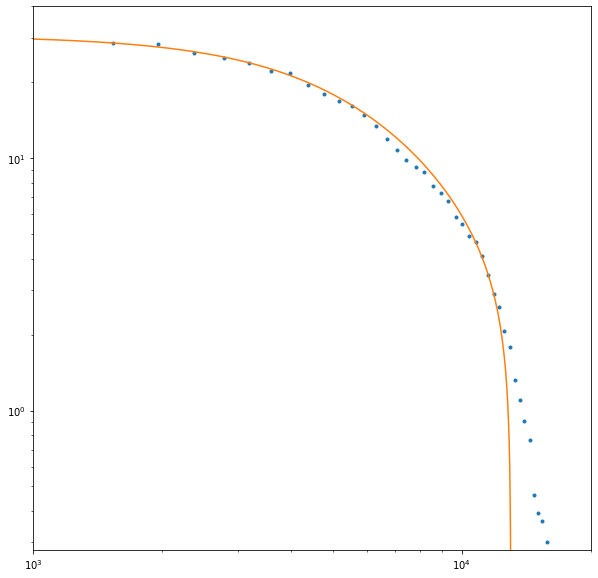

In [189]:
radius_final = np.asarray(xi_sol) * cs / np.sqrt(4.*np.pi*G*rho_center) * 6.68e-12 # AU
vis_final = colden * 2*cs * np.sqrt(rho_center/(4*np.pi*G)) *1e3/1e4 / (coeff)
plt.figure(figsize=(10,10))
plt.plot(df_rau, visual_extinction, '.')
plt.xlim([1e3,2e4])
plt.ylim([0.28,40])
plt.xscale('log')
plt.yscale('log')
plt.plot(radius_final, vis_final[idx_xi,:])
plt.show()

In [190]:
print("xi max = {}".format(xi_sol[idx_xi]))
print("Max radius = {}".format(radius_final[idx_xi]))
print("Center to edge density ratio = {}".format(1/rho_contrast[idx_xi]))

xi max = 5.619999999999902
Max radius = 13014.5115626872
Center to edge density ratio = 10.130276011635589


In [135]:
idx_xi_max = np.argmin(np.abs(np.asarray(xi_sol) - 6.9))
print(idx_xi_max, 1/rho_contrast[idx_xi_max])

1380 16.602704969152946


In [132]:
np.argmin(np.abs(np.asarray(rho_contrast) - 1/16.5))

1377

In [154]:
(6.9 * cs * 6.68e-12 / (12500 * np.sqrt(4*np.pi*G)))**2

1.078462893613741e-15

In [176]:
1.16e21*m_H2*1e3

0.0038525406841580867